# Agnostic & Pose-Guided Target Generator

This notebook generates the two critical inputs for the Virtual Try-on pipeline:
1. **Agnostic Person Image (Stage 3):** A clean background for final fusion.
2. **Target Guidance Parsing (Stage 2):** A neutral target area for the Flow Estimation Module (FEM), guided by **DensePose** to avoid Cloth Shape Bias.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
import os
import cv2
import numpy as np
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt

# --- CONFIGURATION ---
PROJECT_ROOT = Path('/content/drive/MyDrive/virtual_tryon_project')

# Fallback for local testing
if not PROJECT_ROOT.exists():
    print("⚠️ Persistent Drive path not found. Falling back to local search.")
    PROJECT_ROOT = Path.cwd().parent if (Path.cwd().parent / 'data').exists() else Path.cwd()

DATA_ROOT = PROJECT_ROOT / 'data' / 'viton_hd' / 'train'
OUTPUT_ROOT = PROJECT_ROOT / 'virtual-tryon' / 'outputs'

# LIP Labels Mapping
AGNOSTIC_LABELS = [5, 6, 7, 14, 15] # Clothes + Arms
PRESERVE_LABELS = [1, 2, 4, 13]    # Hat, Hair, Sunglasses, Face

print(f"✅ Project Root set to: {PROJECT_ROOT}")

✅ Project Root set to: /content/drive/MyDrive/virtual_tryon_project


## 1. Agnostic Generation (Background)

Replaces the original garment area with a gray mask while preserving the face and hair.

In [11]:
def get_agnostic_person(img_path, parse_path, dilation_kernel_size=25):
    image = np.array(Image.open(img_path).convert("RGB"))
    parse = np.array(Image.open(parse_path).convert("L")) # Ensure parse is a 2D grayscale array

    preserve_mask = np.isin(parse, PRESERVE_LABELS).astype(np.uint8)
    agnostic_mask = np.isin(parse, AGNOSTIC_LABELS).astype(np.uint8)

    kernel = np.ones((dilation_kernel_size, dilation_kernel_size), np.uint8)
    final_agnostic_mask = (cv2.dilate(agnostic_mask, kernel, iterations=1) == 1) & (preserve_mask == 0)

    agnostic_img = image.copy()
    agnostic_img[final_agnostic_mask] = [128, 128, 128]

    return Image.fromarray(agnostic_img)

## 2. DensePose-Guided Target Generation (FEM)

We use the DensePose `dp_segm` output to identify the **actual body surface** of the torso. This provides a neutral, pose-aligned target area that has zero bias from the original garment.

In [12]:
def get_densepose_guidance(parse_path, densepose_path):
    """
    Generates a target guidance map where label 5 includes the Torso AND Arm surfaces.
    This allows the FEM to correctly warp full sleeves even on sleeveless input persons.
    DensePose Labels: 1, 2 = Torso; 11, 13 = L Arm; 12, 14 = R Arm.
    """
    parse = np.array(Image.open(parse_path).convert("L")) # Ensure parse is a 2D grayscale array
    dp_segm = np.array(Image.open(densepose_path).convert("L")) # Ensure dp_segm is a 2D grayscale array

    # 1. Isolate the Torso + Arm region from DensePose
    # This defines the total potential 'canvas' for an upper garment
    # We include torso (1,2) and arm parts (11,12,13,14)
    guidance_mask = np.isin(dp_segm, [1, 2, 11, 12, 13, 14]).astype(np.uint8)

    # 2. Smooth and refine the mask
    kernel = np.ones((5,5), np.uint8)
    neutral_target = cv2.morphologyEx(guidance_mask, cv2.MORPH_CLOSE, kernel, iterations=3)
    neutral_target = cv2.dilate(neutral_target, kernel, iterations=2)

    # 3. Construct Guidance Map
    # Start with original parsing but clear the upper garment area
    guidance = parse.copy()
    guidance[np.isin(parse, [5, 6, 7])] = 0

    # Fill the 'ideal' garment region with label 5 (Upper Clothes)
    guidance[neutral_target == 1] = 5

    return Image.fromarray(guidance)

## 3. Execution & Visualization

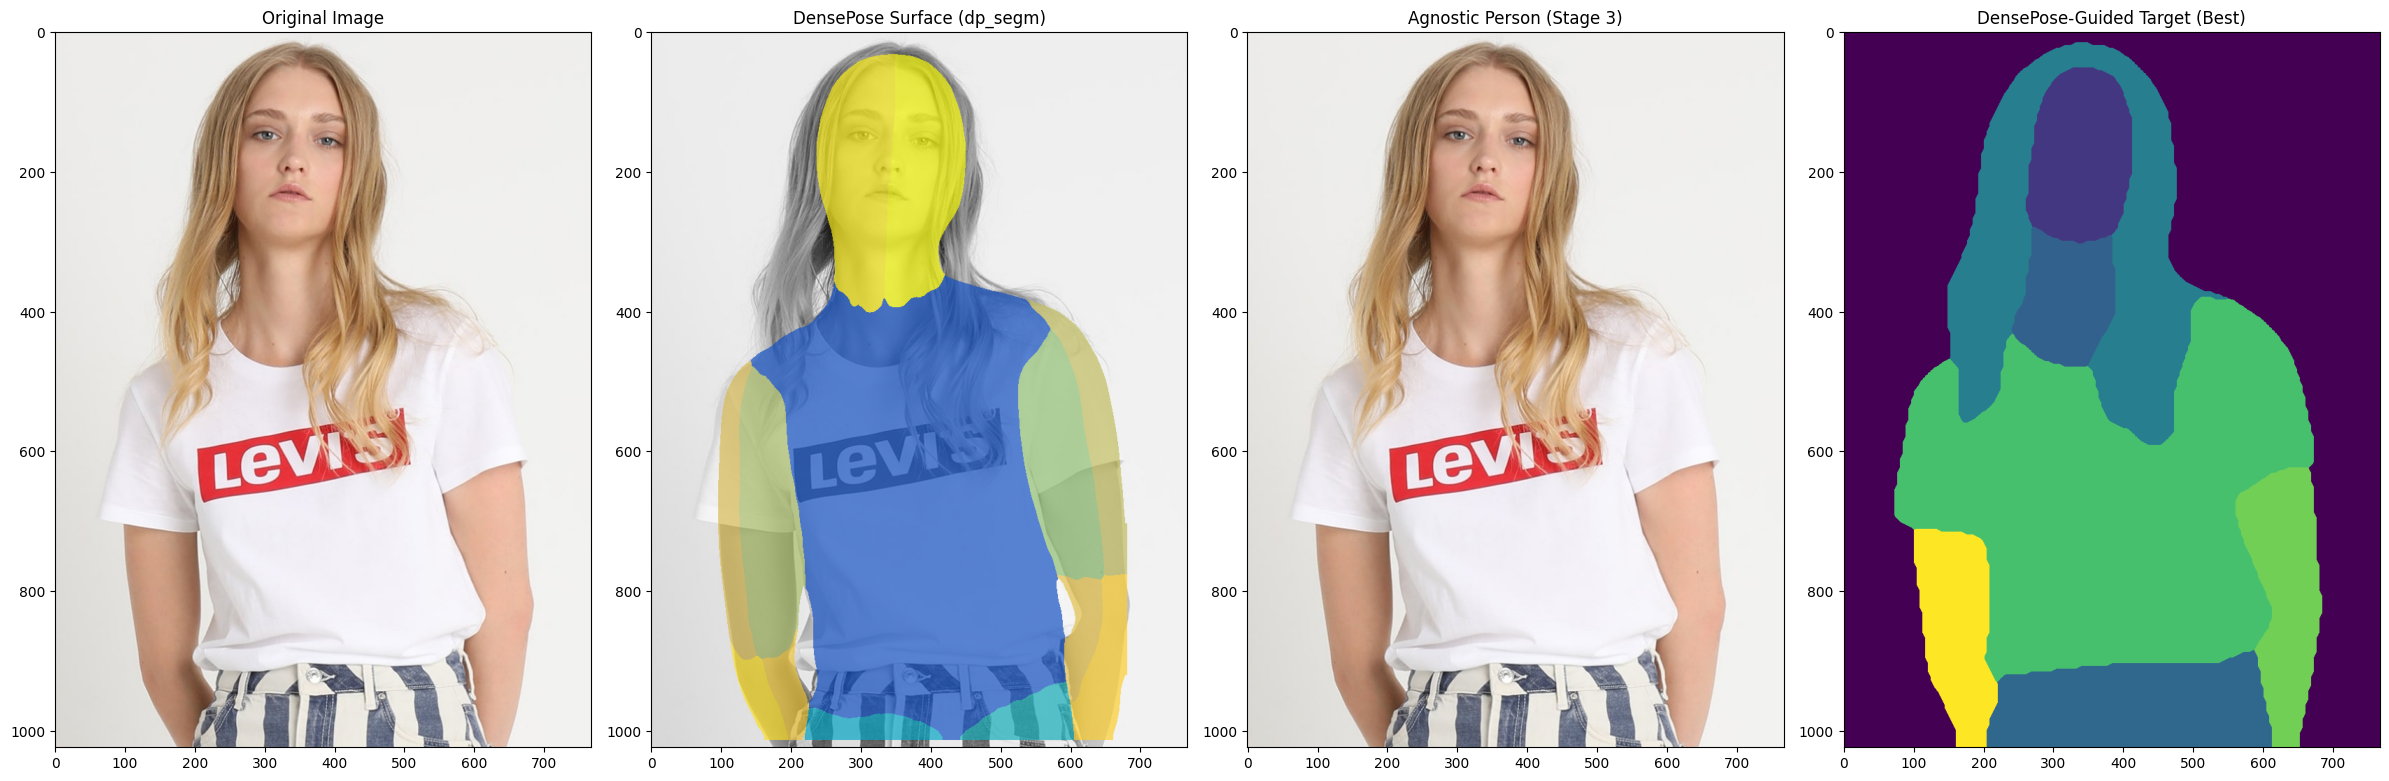

In [13]:
person_id = "00005_00.jpg"

img_path = DATA_ROOT / 'image' / person_id
parse_path = DATA_ROOT / 'image-parse-v3' / person_id.replace('.jpg', '.png')
dp_path = OUTPUT_ROOT / 'densepose' / person_id.replace('.jpg', '_segm.0001.png')

if img_path.exists() and parse_path.exists():
    agn_img = get_agnostic_person(img_path, parse_path)

    # If you have already run DensePose, use it for best results
    if dp_path.exists():
        guidance_map = get_densepose_guidance(parse_path, dp_path)
        title = "DensePose-Guided Target (Best)"
    else:
        print("⚠️ DensePose output not found for this image. Using fallback morphological smoothing.")
        # Simple fallback if DensePose results aren't ready yet
        from PIL import ImageFilter
        guidance_map = Image.open(parse_path).filter(ImageFilter.ModeFilter(size=13))
        title = "Morphological Fallback"

    # Visualize
    fig, axes = plt.subplots(1, 4, figsize=(24, 8))
    axes[0].imshow(Image.open(img_path))
    axes[0].set_title("Original Image")

    if dp_path.exists():
        axes[1].imshow(Image.open(dp_path))
        axes[1].set_title("DensePose Surface (dp_segm)")

    axes[2].imshow(agn_img)
    axes[2].set_title("Agnostic Person (Stage 3)")

    axes[3].imshow(guidance_map)
    axes[3].set_title(title)

    plt.tight_layout()
    plt.show()
else:
    print(f"Missing data: Checked {img_path}")